In [42]:
!pip install scipy scikit-image shapely pandas omero2pandas

   ---------------------------------------- 1.4/1.4 MB 5.4 MB/s eta 0:00:00


In [4]:
import ezomero as ez
from getpass import getpass
import numpy as np
import PIL
import matplotlib.pyplot as plt
import scipy as sp
import skimage as ski
from shapely.geometry import LineString

In [5]:
USER = "participant-a"
PWD = getpass(prompt=f"Password for {USER}")
OMERO_GROUP = "Workshop Metadata Annotation"
HOST = "wss://omero-training.gerbi-gmb.de/omero-wss"
PORT = 443

Password for participant-a ········


In [49]:
conn = ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True)
print(f"Is connected: {conn.isConnected()}")

Is connected: True


# Disclaimer
#### This analysis example is to illustrate how to batch process images on OMERO.
#### It shouldn't be used as such for your data analysis

## The data: High content screening (there's enough images for everyone)

Source: https://idr.openmicroscopy.org/webclient/?show=screen-3151

In [4]:
plate_id = 151
for i, well_id in enumerate(ez.get_well_ids(conn, plate=plate_id)):
    print(ez.get_image_ids(conn, well=well_id))
    if i == 10:
        break  # Exit the loop after 10 iterations

[27923, 27924, 27925, 27926, 27927, 27928, 27929, 27930, 27931]
[27932, 27933, 27934, 27935, 27936, 27937, 27938, 27939, 27940]
[27941, 27942, 27943, 27944, 27945, 27946, 27947, 27948, 27949]
[27950, 27951, 27952, 27953, 27954, 27955, 27956, 27957, 27958]
[27959, 27960, 27961, 27962, 27963, 27964, 27965, 27966, 27967]
[27968, 27969, 27970, 27971, 27972, 27973, 27974, 27975, 27976]
[27977, 27978, 27979, 27980, 27981, 27982, 27983, 27984, 27985]
[27986, 27987, 27988, 27989, 27990, 27991, 27992, 27993, 27994]
[27995, 27996, 27997, 27998, 27999, 28000, 28001, 28002, 28003]
[28004, 28005, 28006, 28007, 28008, 28009, 28010, 28011, 28012]
[28013, 28014, 28015, 28016, 28017, 28018, 28019, 28020, 28021]


In [5]:
print(f"Number of wells in plate {plate_id}: {len(ez.get_well_ids(conn, plate=plate_id))} wells")

Number of wells in plate 151: 345 wells


### Prepare the whole segmentation workflow for a single image

#### Opening an image, first channel only (nuclei)

In [6]:
img_id = 27932
img_obj, px = ez.get_image(conn, img_id, start_coords=[0,0,0,0,0], axis_lengths=[2080, 1552, 1, 1, 1])
px = np.squeeze(px)

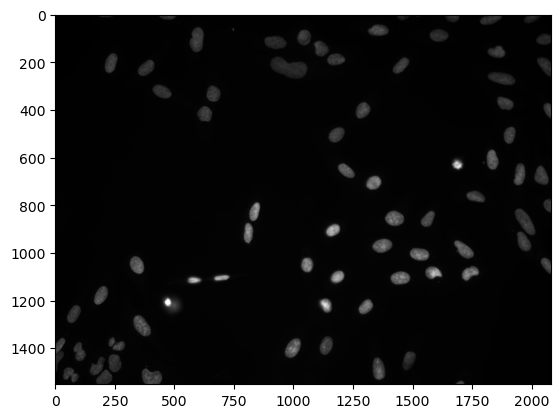

In [7]:
plt.figure()
plt.imshow(px, cmap="gray")

#### Making a histogram of pixel values

C:\Users\ThinkPad_Ryzen7\AppData\Local\Temp\ipykernel_25964\700764665.py:2: RuntimeWarning: divide by zero encountered in log
  count = np.log(count)  # Bin counts to log for better visualization


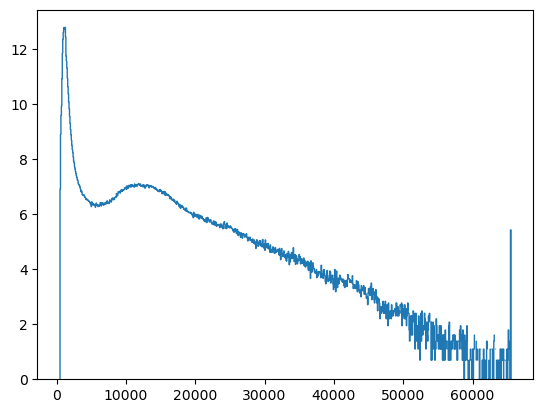

In [14]:
count, bins = np.histogram(px, bins=1000)
count = np.log(count)  # Bin counts to log for better visualization

plt.figure()
plt.stairs(count, bins)

We see a dip at around value of 5000. If we do a threshold with that value, we already get interesting results.

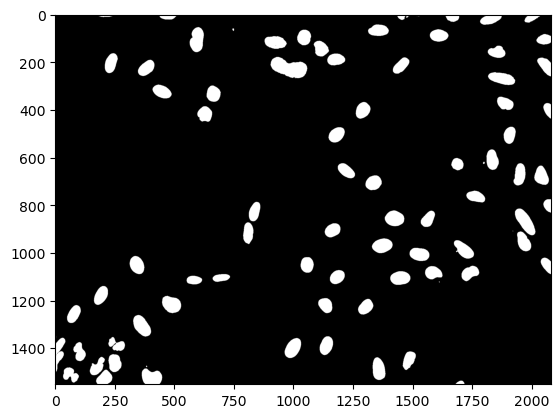

In [66]:
mask = px > 6000

plt.figure()
plt.imshow(mask, cmap="gray")

In [22]:
# Filling holes in the mask as a precaution
mask = sp.ndimage.binary_fill_holes(mask)

We can then use scipy.ndimage.label to detect connected regions

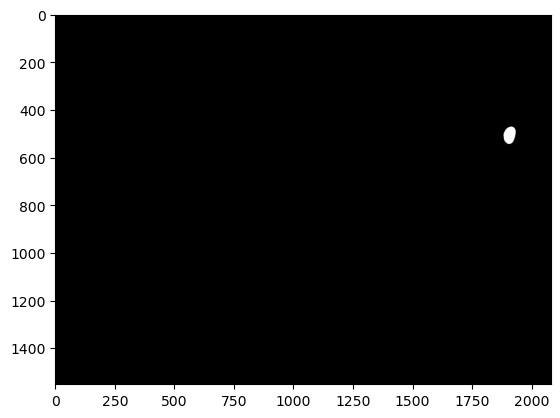

In [24]:
regions, n_regions = sp.ndimage.label(mask)
plt.figure()
plt.imshow(regions == 30, cmap="gray")  # regions == 30  ->  get the region assigned to pixel values 30

Overlay results with original image

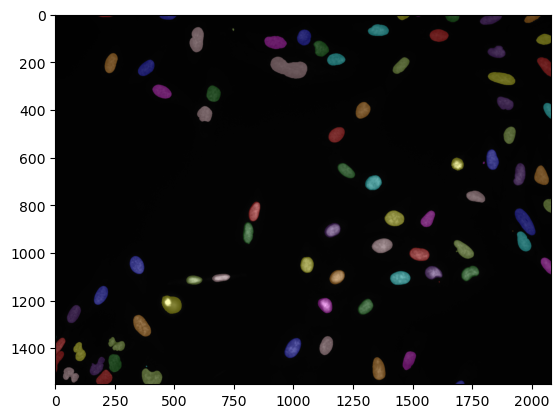

In [25]:
plt.figure()
plt.imshow(ski.color.label2rgb(sp.ndimage.label(mask)[0], px))

The next step computes the contours of a single nucleus. 

In [55]:
contours = ski.measure.find_contours(regions.T == 30, level=.5)[0]   # regions is transposed, otherwise poylgon X&Y coordinates are reversed
line = LineString(contours)  # From shapely
simplified_line = line.simplify(tolerance=1.0)  # Adjust tolerance
simplified_coords = np.array(simplified_line.coords)

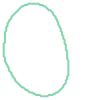

In [59]:
line

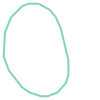

In [60]:
simplified_line  # Simplified to reduce the number of points in the polygon

In [56]:
ez.post_roi(conn, image_id=img_id, shapes=[ez.rois.Polygon(simplified_coords)])  # Post a single ROI as example

24111

### Posting all nuclei for our example image

In [61]:
polys = []
for val in range(1, np.max(regions)+1): # For every region
    if np.sum(regions.T == val) < 1000:
        # Region is too small, let's skip it
        continue
    contours = ski.measure.find_contours(regions.T == val, level=.5)[0]   # regions is transposed, otherwise poylgon X&Y coordinates are reversed
    line = LineString(contours)  # From shapely
    simplified_line = line.simplify(tolerance=1.0)  # Adjust tolerance
    simplified_coords = np.array(simplified_line.coords)
    polys.append(ez.rois.Polygon(simplified_coords))

ez.post_roi(conn, image_id=img_id, shapes=polys)  # Post a all ROIs

# Refining
The segmentation worked for this image, but what about the next?
The threshold would certainly vary from the example image to any other image of our dataset.<br/>
==> We need a way to compute the ideal threshold for each image

9645


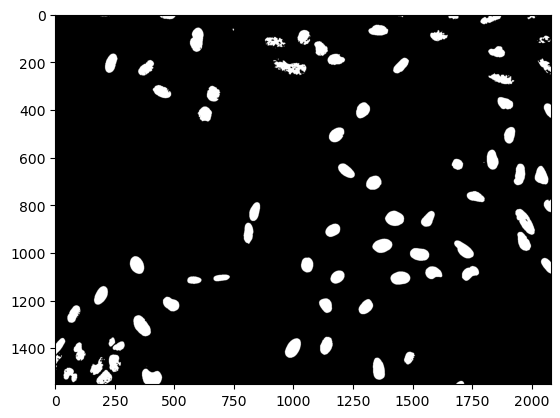

In [68]:
threshold = ski.filters.threshold_otsu(image=px, nbins=1024)
print(threshold)

mask = px > threshold
plt.figure()
plt.imshow(mask, cmap="gray")

Looks good enough =)

# Iterate over ALL images (maybe not, a single Well will be enough)

In [73]:
with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    # The with statement opens the connection, and closes it once the code exit
    # This is considered good practice
    
    # plate_id = 151
    # for i, well_id in enumerate(ez.get_well_ids(conn, plate=plate_id)):
        well_id = 1901
        for img_id in ez.get_image_ids(conn, well=well_id):
            img_obj, px = ez.get_image(conn, img_id, start_coords=[0,0,0,0,0], axis_lengths=[2080, 1552, 1, 1, 1])
            px = np.squeeze(px)

            threshold = ski.filters.threshold_otsu(image=px, nbins=1024)
            mask = px > threshold
            
            # Filling holes in the mask as a precaution
            mask = sp.ndimage.binary_fill_holes(mask)
            
            regions, n_regions = sp.ndimage.label(mask)
        
            polys = []
            for val in range(1, np.max(regions)+1): # For every region
                if np.sum(regions.T == val) < 1000:
                    # Region is too small, let's skip it
                    continue
                contours = ski.measure.find_contours(regions.T == val, level=.5)[0]   # regions is transposed, otherwise poylgon X&Y coordinates are reversed
                line = LineString(contours)  # From shapely
                simplified_line = line.simplify(tolerance=1.0)  # Adjust tolerance
                simplified_coords = np.array(simplified_line.coords)
                polys.append(ez.rois.Polygon(simplified_coords))
            
            ez.post_roi(conn, image_id=img_id, shapes=polys)  # Post a all ROIs
            print(f"Found {len(polys)} nuclei for image:{img_id}")
            break

Found 106 nuclei for image:27923


# OMERO.table

In [2]:
import omero2pandas
import pandas as pd

In [6]:
conn = ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True)

In [54]:
tmp_d = {"well": [], "image": [], "roi": [], "shape": [], "c0_sum": [], "c1_sum": []}
well_id = 1901
for img_id in ez.get_image_ids(conn, well=well_id):
    for roi_id in ez.get_roi_ids(conn, img_id):
        for shape_id in ez.get_shape_ids(conn, roi_id):
            shape = ez.get_shape(conn, shape_id)
            points = np.array(shape.points)
            x_min, x_max = int(points[:,0].min()), int(points[:,0].max())
            y_min, y_max = int(points[:,1].min()), int(points[:,1].max())
    
            img_o, px_roi = ez.get_image(conn, img_id, start_coords=[x_min, y_min, 0, 0, 0], axis_lengths=[x_max-x_min, y_max-y_min, 1, 5, 1])
            px_roi = np.squeeze(px_roi)
            tmp_d["well"].append(well_id)
            tmp_d["image"].append(img_id)
            tmp_d["roi"].append(roi_id)
            tmp_d["shape"].append(shape_id)
            tmp_d["c0_sum"].append(np.sum(px_roi[:,:,0]))
            tmp_d["c1_sum"].append(np.sum(px_roi[:,:,0]))
            break
        break
    break

In [59]:
df = pd.DataFrame.from_dict(tmp_d)
df

,well,image,roi,shape,c0_sum,c1_sum
0,1901,27923,24118,24603,55100175,55100175


In [64]:
omero2pandas.create_table(df, "tom_analysis", links=[("Plate", 151)], conn=conn, chunk_size=100000)

Uploading table to OMERO: : 100%|████████████████████████████████████████████████████████████████████| 1/1 rows, 00:00 


7657

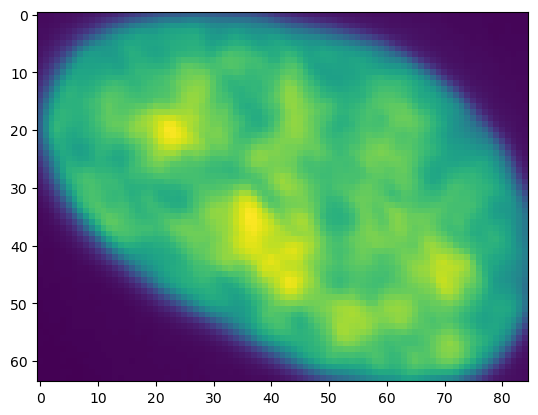

In [52]:
plt.figure()
plt.imshow(np.squeeze(px_roi)[:,:,0])